In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf

### read data

In [2]:
data = pd.read_csv('./data/Google_Historical_StockPrice2.csv')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1260 entries, 0 to 1259
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1260 non-null   object 
 1   Open       1260 non-null   float64
 2   High       1260 non-null   float64
 3   Low        1260 non-null   float64
 4   Close      1260 non-null   float64
 5   Adj Close  1260 non-null   float64
 6   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 69.0+ KB


make data an index

In [3]:
data.Date = pd.to_datetime(data.Date)
data.set_index('Date', inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1260 entries, 2016-03-28 to 2021-03-26
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       1260 non-null   float64
 1   High       1260 non-null   float64
 2   Low        1260 non-null   float64
 3   Close      1260 non-null   float64
 4   Adj Close  1260 non-null   float64
 5   Volume     1260 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 68.9 KB


In [4]:
len(data.Open.notna()) == len(data.Open)

True

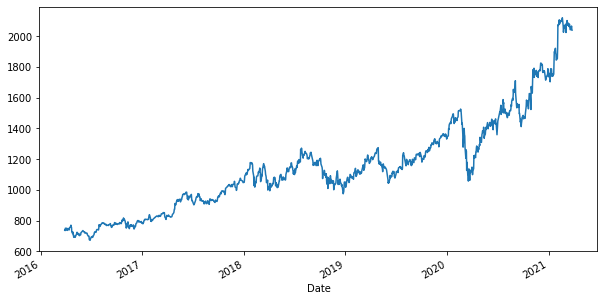

In [5]:
data.Open.plot(figsize=(10,5))

average data by weeks

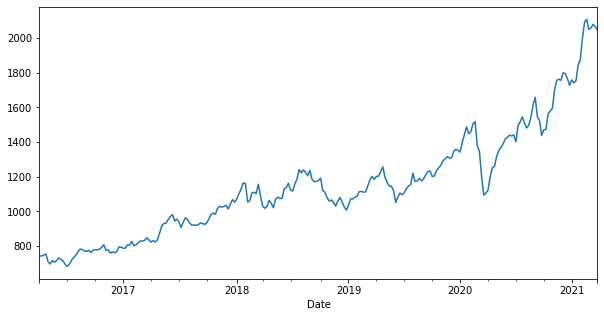

In [6]:
d = data.Open.resample('W').mean()
d.plot(figsize=(10,5))

trend and increasing variance can be seen.

Dickey-Fuller test

In [7]:
def df_test(d):
    test = sm.tsa.adfuller(d)
    print('adf:', test[0])
    print('p-value:', test[1])
    print('critical values:', test[4])
    if test[0] > test[4]['5%']:
        print('ряд не стационарен')
    else:
        print('ряд стационарен!')

df_test(d)

adf: 0.3643531494219944
p-value: 0.9801118037201112
critical values: {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}
ряд не стационарен


autocorrelation helps with seasonality detection

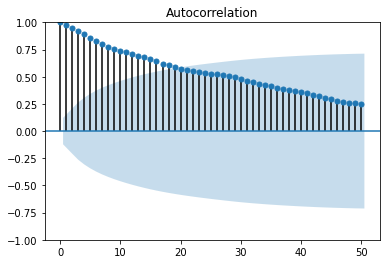

In [8]:
plot_acf(d, lags=50)
plt.show()

no seasonality yet, let's log the series

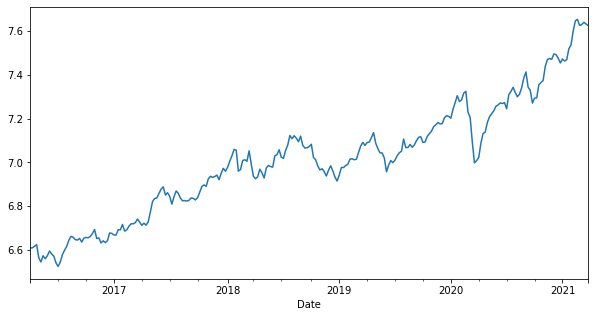

In [9]:
d = d.apply(np.log)
d.plot(figsize=(10,5))

In [10]:
df_test(d)

adf: -0.26640283135467124
p-value: 0.9301297503171618
critical values: {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}
ряд не стационарен


diff the series

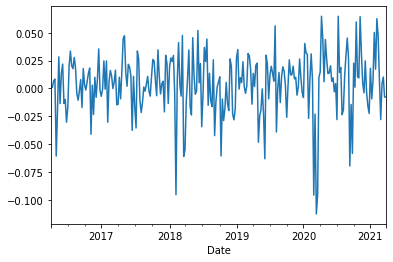

In [11]:
def undiff(orig, diffed):
    res = orig.copy()
    return (orig.shift(1) + diffed).fillna(orig[0])

def undiff2(orig, diffed):
    offset = orig[0]
    arr = diffed.cumsum()
    arr += offset
    return arr

def undiff3(orig, diffed):
    arr = diffed.copy()
    arr[0] = orig[0]
    return arr.cumsum()

dd = d.diff(periods=1)
dd.plot()

In [12]:
d.equals(undiff3(d, d.diff(1)))

True

In [13]:
df_test(dd.dropna())

adf: -13.10989089710007
p-value: 1.6431080436188033e-24
critical values: {'1%': -3.4558530692911504, '5%': -2.872764881778665, '10%': -2.572751643088207}
ряд стационарен!


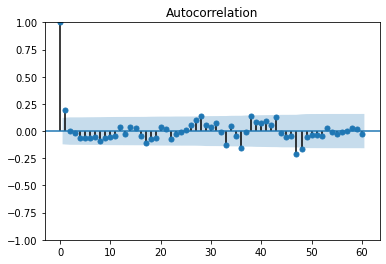

In [14]:
plot_acf(dd.dropna(), lags=60)
plt.show()

0.003906547281375619


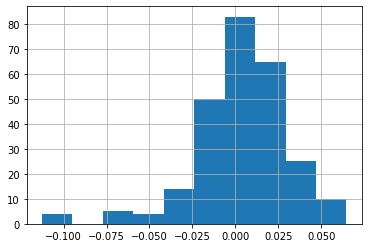

In [15]:
dd.dropna().hist()
print(dd.dropna().mean())

sounds good.

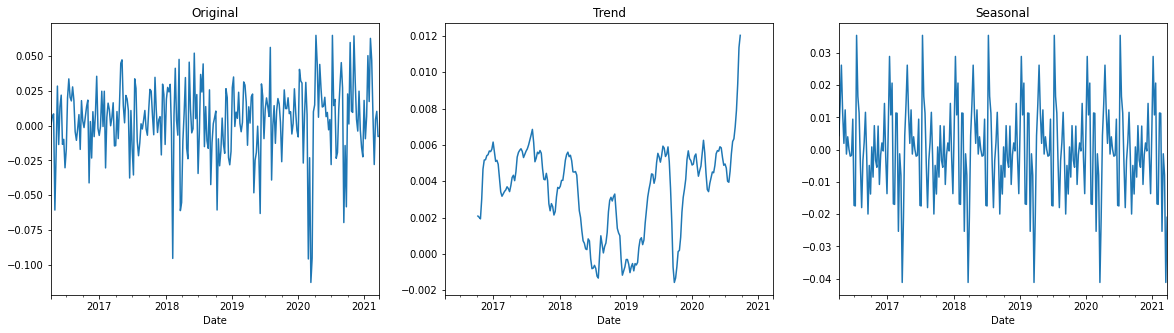

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

result = seasonal_decompose(dd.dropna())
ax[0].set_title('Original')
ax[1].set_title('Trend')
ax[2].set_title('Seasonal')

result.observed.plot(ax=ax[0])
result.trend.plot(ax=ax[1])
result.seasonal.plot(ax=ax[2])
plt.show()

it seems like a trend can be seen anyway, but it is insignificant.

### Prediction

80% of data: 210
20% of data: 50


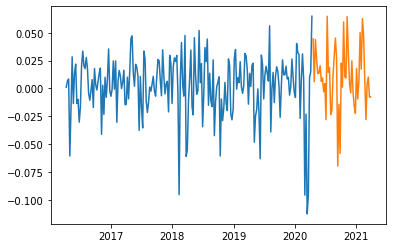

In [17]:
split_by = int(len(dd)*0.81)
train = dd[1:split_by]
test = dd[split_by:]
print('80% of data:', len(train))
print('20% of data:', len(test))
plt.plot(train)
plt.plot(test)
plt.show()

In [18]:
def HolterWinter(data, L, alpha, beta, gamma, m):
    # находим изначальные сезонности
    season_num = int(len(data)/L)# кол-во cезонов
    seasonalities = {} # сами сезонности
    season_avgs = [] # их среднее
    # находим сезонное среднее
    season_avgs = [sum(data[L*i: L*i+L])/float(L) for i in range(season_num)]
    # находим начальные значения cезонности
    for i in range(L):
        avg_over_summ = 0.0
        for j in range(season_num):
            avg_over_summ += data[L*j+i] - season_avgs[j]
        seasonalities[i] = avg_over_summ / season_num
    # инициализируем массивы результирующих прогнозов, сгалженных, сезонных и трендовых (нужны в формулах на пред шагах)
    result = []
    smooth = []
    season = []
    trend = []
    # пройдемся по всем данным + длинна предсказания m
    for i in range(len(data) + m):
        # инициализируем значения шага 0
        if i==0:
            smooth_val = data[0] # первое значения сглаживания
            trend_val = sum([(float(data[i+L] - data[i]) / L) for i in range(L)]) / L # первое значения тренда
            result.append(data[0]) # первая точка данных совпадает с исходной
            smooth.append(smooth_val) # добавляем первое значение сглаживание в массив трендов
            trend.append(trend_val) # добавляем первое значение тренда в массив трендов
            season.append(seasonalities[i%L]) # см mod L
            continue # завершаем первый шаг
        # выполняем прогноз, если вышли за пределы данных
        if i >= len(data):
            # текущее прогнозируемое значение t+1, t+2, ... (текущее m)
            curr_m = i - len(data) + 1
            result.append((smooth_val + curr_m*trend_val) + seasonalities[i%L])
        else: # основной цикл вычисления параметров
            last_smooth_val = smooth_val
            smooth_val = alpha*(data[i] - seasonalities[i%L]) + (1 - alpha)*(smooth_val + trend_val) # обновляем lx
            trend_val = beta * (smooth_val - last_smooth_val) + trend_val*(1 - beta) # обновляем bx
            seasonalities[i%L] = gamma * (data[i] - smooth_val) + (1 - gamma)*seasonalities[i%L] # обновляем sx
            result.append(smooth_val + trend_val + seasonalities[i%L]) # записываем результат

            smooth.append(smooth_val)
            trend.append(trend_val)
            season.append(seasonalities[i%L])
    return result[-m:]

In [19]:
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

def predict(train, m, alpha, beta, gamma):
    return HolterWinter(train, L = 52, alpha=alpha, beta=beta, gamma=gamma, m=m)

def check(x):
    alpha, beta, gamma = x
    preds = predict(train, len(test), alpha, beta, gamma)
    return mean_squared_error(preds[-len(test):], test)

# Минимизируем функцию потерь с ограничениями на параметры
optimizer = minimize(check, x0=[0, 0, 0], method="L-BFGS-B", bounds = ((0, 1), (0, 1), (0, 1)))

# Из оптимизатора берем оптимальное значение параметров
alpha, beta, gamma = optimizer.x
print(alpha, beta, gamma, check(optimizer.x))

0.0010196092323883088 9.608889540920099e-06 2.564947304712102e-05 0.0007768996455653387


visualize train & test

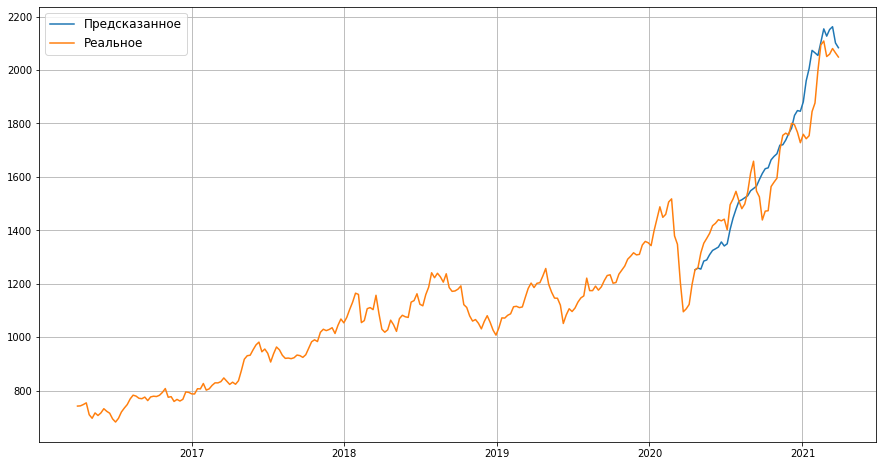

In [20]:
from pandas import Series

index = index=pd.date_range(dd.index[split_by], periods=len(test), freq='W')
predicted = Series(predict(train, len(test), alpha, beta, gamma), index=index)

plt.figure(figsize=(15, 8))
plt.plot(undiff3(d[split_by:], predicted).apply(lambda x: np.exp(x)), label = "Предсказанное")
plt.plot(d.apply(lambda x: np.exp(x)), label = "Реальное")
plt.grid(True)
plt.legend(fontsize=12)
plt.show()

#### SARIMA

In [21]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [22]:
from pmdarima.arima import auto_arima

In [23]:
model = auto_arima(train, start_p=1, start_q=1, test='adf', max_p=2, max_q=1, m=52,
           start_P=0, max_P=1, max_Q=1, d=0, D=1, seasonal=True, error_action ='ignore', supress_warnings=True, trace=True)

model.summary()

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=39.31 sec
 ARIMA(0,0,0)(0,1,0)[52] intercept   : AIC=-574.501, Time=0.80 sec
 ARIMA(1,0,0)(1,1,0)[52] intercept   : AIC=-613.283, Time=22.67 sec
 ARIMA(0,0,1)(0,1,1)[52] intercept   : AIC=inf, Time=21.50 sec
 ARIMA(0,0,0)(0,1,0)[52]             : AIC=-576.451, Time=0.50 sec
 ARIMA(1,0,0)(0,1,0)[52] intercept   : AIC=-577.057, Time=0.65 sec
 ARIMA(1,0,0)(1,1,1)[52] intercept   : AIC=inf, Time=41.21 sec
 ARIMA(1,0,0)(0,1,1)[52] intercept   : AIC=inf, Time=20.96 sec
 ARIMA(0,0,0)(1,1,0)[52] intercept   : AIC=-611.337, Time=15.40 sec
 ARIMA(2,0,0)(1,1,0)[52] intercept   : AIC=-611.551, Time=39.00 sec
 ARIMA(1,0,1)(1,1,0)[52] intercept   : AIC=-611.473, Time=26.24 sec
 ARIMA(0,0,1)(1,1,0)[52] intercept   : AIC=-613.530, Time=13.80 sec
 ARIMA(0,0,1)(0,1,0)[52] intercept   : AIC=-577.916, Time=1.81 sec
 ARIMA(0,0,1)(1,1,1)[52] intercept   : AIC=inf, Time=39.37 sec
 ARIMA(0,0,1)(1,1,0)[52]          

<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                      
===========================================================================================
Dep. Variable:                                   y   No. Observations:                  210
Model:             SARIMAX(0, 0, 1)x(1, 1, [], 52)   Log Likelihood                 310.710
Date:                             Tue, 11 Oct 2022   AIC                           -615.419
Time:                                     15:30:49   BIC                           -606.231
Sample:                                 04-10-2016   HQIC                          -611.688
                                      - 04-12-2020                                         
Covariance Type:                               opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.1695      0.084      2.011      0.044       0.004       0.335
ar.S.L52      -0.5600      0.065     -8.619      0.000      -0.687      -0.433
sigma2         0.0010   7.09e-05     14.280      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                83.07
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               2.19   Skew:                            -0.81
Prob(H) (two-sided):                  0.00   Kurtosis:                         6.16
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [24]:
fitted, confint = model.predict(n_periods=len(test), return_conf_int=True)
print(mean_squared_error(test, fitted))

#print(fitted)

0.0009511058593577943


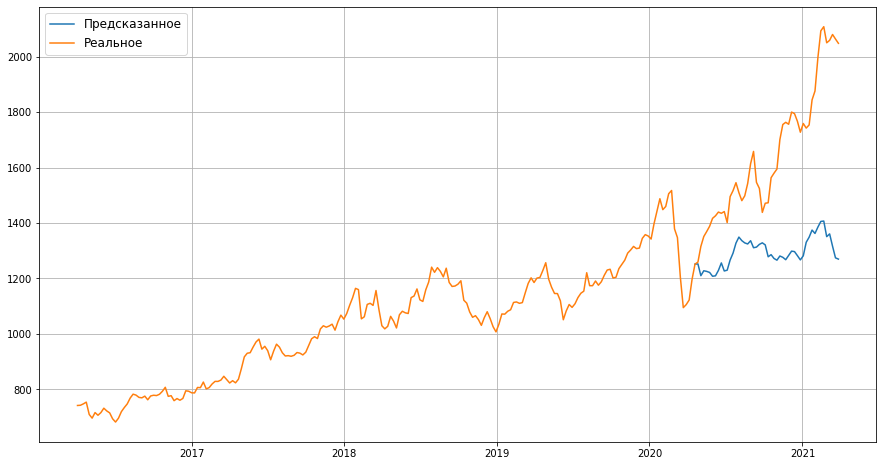

In [25]:
plt.figure(figsize=(15, 8))
plt.plot(undiff3(d[split_by:], fitted).apply(lambda x: np.exp(x)), label = "Предсказанное")
plt.plot(d.apply(lambda x: np.exp(x)), label = "Реальное")
plt.grid(True)
plt.legend(fontsize=12)
plt.show()